In [247]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [248]:
def sharpen_image(img):
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0],
    ])
    return cv2.filter2D(img, -1, kernel)

(-0.5, 209.5, 369.5, -0.5)

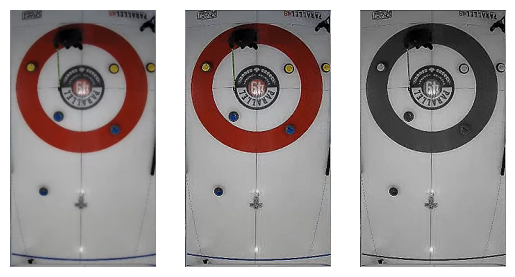

In [249]:
file = "data/lots.png"

img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sharp = sharpen_image(img)
bw = cv2.cvtColor(sharp, cv2.COLOR_RGB2GRAY)

plt.subplot(131)
plt.imshow(img); plt.axis('off')

plt.subplot(132)
plt.imshow(sharp); plt.axis('off')

plt.subplot(133)
plt.imshow(bw, cmap = "gray"); plt.axis('off')

In [250]:
class HouseDetect:

    def __init__(self, image = None):
        if image is not None:
            self.original = image.copy()

    def estimate_center(self, img):
        self.image = self.process_image(img)
        canny = cv2.Canny(self.image, 100, 200)
        self.canny = cv2.GaussianBlur(canny, ksize=(5, 5), sigmaX=1)

        centers, diameters = self.detect_circles(self.canny)

        min_diam = 70
        max_diam = 1e3
        std_range = 0.75
        centers, diameters = self.filter_circles(centers, diameters, min_diam, max_diam, std_range)


        if centers is not None:
            return centers.mean(axis = 0).astype(np.int64)
        else:
            return None

    def show_center(self, draw_img, center_coords, text = True, color = (0, 255, 0)):
        cv2.circle(
            draw_img,
            center_coords,
            radius = 2,
            thickness = -1,
            color = color
        )


        if text:
            text_add = np.array([-30, -10])

            cv2.putText(
                draw_img,
                f"Center",
                center_coords + text_add,
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2,
                cv2.LINE_AA
            )

    def process_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sharp = sharpen_image(img)
        return cv2.cvtColor(sharp, cv2.COLOR_RGB2GRAY)

    def detect_circles(self, canny):
        contours, _ = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        axes = np.full((len(contours), 2), fill_value=-1)
        centers = np.full_like(axes, fill_value=-1)

        for n, contour in enumerate(contours):

            if len(contour) > 5:
                ellipse = cv2.fitEllipse(contour)
                centers[n], axes[n], _ = ellipse

        mask = np.all(axes > 1, axis=1)
        axes = axes[mask]
        centers = centers[mask]
        ratio = np.max(axes, axis=1) / np.min(axes, axis=1)

        mask = ratio < 1.2
        axes = axes[mask]

        centers = centers[mask].astype(np.int32)
        diameters = axes.mean(axis=1)
        mask = np.logical_and(diameters > 70, diameters < 550)

        centers = centers[mask]
        diameters = diameters[mask]

        return (centers, diameters)

    def filter_circles(self, center, diam, min, max, std_range):
        mask = np.logical_and(diam > min, diam < max)
        center = center[mask]
        diameter = diam[mask]

        std = center.std(axis=0)
        means = center.mean(axis=0)

        if np.any(std > 10):
            within_std = std * np.array([
                [-std_range],
                [ std_range]
            ]) + means

            lower_bound = np.all(center > within_std[0], axis=1)
            upper_bound = np.all(center < within_std[1], axis=1)
            mask = np.logical_and(lower_bound, upper_bound)

            center = center[mask]
            diameter = diameter[mask]

        if len(center) != 0:
            return (center, diameter)
        else:
            return None, None

    def filter_ice(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        lower = np.array([0, 0, 30], dtype=np.uint8)
        upper = np.array([255, 130, 210], dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
        no_ice = cv2.bitwise_and(hsv, hsv, mask=np.invert(mask))
        return cv2.cvtColor(no_ice, cv2.COLOR_HSV2RGB)

    def filter_house(self, img, iterations = 3):

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        lower = np.array([
          10,
          100,
          0
        ], dtype=np.uint8)
        upper = np.array([
          200,
          255,
          150
        ], dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)

        # mask = np.bitwise_or(mask1, mask2)

        # mask = cv2.erode(
        #     mask,
        #     kernel = (11, 11),
        #     iterations=iterations
        # )
        # mask = cv2.dilate(
        #     mask,
        #     kernel=(11, 11),
        #     iterations=iterations
        # )

        return cv2.bitwise_and(img, img, mask=mask), mask

(-0.5, 209.5, 369.5, -0.5)

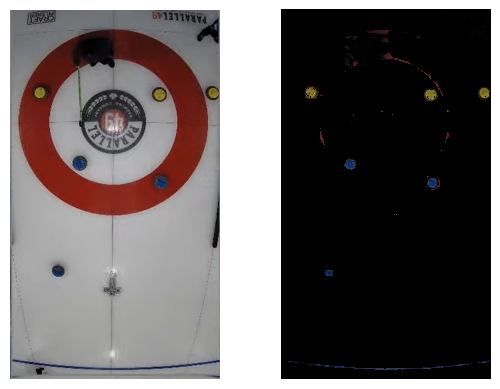

In [251]:
og = img.copy()
House = HouseDetect(img)

# img = House.filter_ice(img)
img, mask = House.filter_house(img, iterations=0)
# img = np.where(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) > 0, 255, 0).astype(np.uint8)
#
plt.subplot(121)
plt.imshow(og); plt.axis('off')

plt.subplot(122)
plt.imshow(img); plt.axis('off')


In [252]:
contours,hierarchy = cv2.findContours(img.astype(np.uint8), 1, 2)

# plt.subplot(121)
# plt.imshow(cv2.drawContours(og.copy(), contours, -1, (0, 255, 0), 3))
#
# plt.subplot(122)
# plt.imshow(img)

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [ ]:
convexImg = og.copy()
blank = np.zeros_like(convexImg)
for contour in contours:
    hull = cv2.convexHull(contour)
    area = cv2.contourArea(hull)
    if area > 20:
        moment = cv2.moments(hull)
        # print()
        # print(moment)
        cv2.drawContours(convexImg, hull, -1, (0, 255, 0), 3)
        ellipse = cv2.fitEllipse(hull)
        cv2.ellipse(convexImg,ellipse,(255,0,0),2)
        print(ellipse[0])

plt.subplot(121)
plt.imshow(convexImg)

plt.subplot(122)
plt.imshow(blank)